In [26]:
import os
import shutil
import torch
import torch.utils.data
import torchvision
from PIL import Image, ImageDraw
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import cv2
import copy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import random
import json

In [201]:
confidences = 'bioclip/0_probs.json'
labels = 'bioclip/instances_default.json'

In [202]:
vector_mapping = json.load(open('bioclip/species_vector_mapping.json', 'r'))
print(vector_mapping)

{'num_species': 210, 'species_id_to_index': {'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, '9': 8, '10': 9, '11': 10, '12': 11, '13': 12, '14': 13, '15': 14, '16': 15, '17': 16, '18': 17, '19': 18, '20': 19, '21': 20, '22': 21, '23': 22, '24': 23, '25': 24, '26': 25, '27': 26, '28': 27, '29': 28, '30': 29, '31': 30, '32': 31, '33': 32, '34': 33, '35': 34, '36': 35, '37': 36, '38': 37, '39': 38, '40': 39, '41': 40, '42': 41, '43': 42, '44': 43, '45': 44, '46': 45, '47': 46, '48': 47, '49': 48, '50': 49, '51': 50, '52': 51, '53': 52, '54': 53, '55': 54, '56': 55, '57': 56, '58': 57, '59': 58, '60': 59, '61': 60, '62': 61, '63': 62, '64': 63, '65': 64, '66': 65, '67': 66, '68': 67, '69': 68, '70': 69, '71': 70, '72': 71, '73': 72, '74': 73, '75': 74, '76': 75, '77': 76, '78': 77, '79': 78, '80': 79, '81': 80, '82': 81, '83': 82, '84': 83, '85': 84, '86': 85, '87': 86, '88': 87, '89': 88, '90': 89, '91': 90, '92': 91, '93': 92, '94': 93, '95': 94, '96': 95, '97': 96, '98'

In [203]:
coco = COCO(labels)
ids = list(sorted(coco.imgs.keys()))

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!


In [204]:
data = pd.read_csv('bioclip/images_in_training.txt')
img_in_training = set()
for row_id, row in data.iterrows():
    img = row[0]
    img_in_training.add(img[::-1][:img[::-1].find('/')][::-1])
print(img_in_training)

{'tree_Jaipur_Jaipur_13_28_low_density_near_north_0_20250526_073615_290610.jpg', 'tree_Jhunjhunu_Jhunjhunu_2_57_low_density_near_northeast_0_20250526_061300_377457.jpg', 'tree_Jhunjhunu_Jhunjhunu_5_71_low_density_far_southwest_0_20250526_063844_450563.jpg', 'tree_Sikar_Sikar_8_19_low_density_near_north_0_20250526_070137_838523.jpg', 'tree_Jaipur_Jaipur_5_271_low_density_near_southeast_0_20250526_064245_878303.jpg', 'tree_Nagaur_Nagaur_4_386_low_density_near_west_0_20250526_063626_940613.jpg', 'tree_Jaipur_Jaipur_3_193_low_density_near_west_0_20250526_062456_192858.jpg', 'tree_Nagaur_Nagaur_9_113_low_density_near_east_0_20250526_070746_972683.jpg', 'tree_Nagaur_Nagaur_16_26_low_density_near_center_0_20250526_080116_510711.jpg', 'tree_Jhunjhunu_Jhunjhunu_16_122_low_density_near_center_0_20250526_080321_774401.jpg', 'tree_Alwar_Alwar_14_12_low_density_near_east_0_20250526_074400_872349.jpg', 'tree_Nagaur_Nagaur_6_106_low_density_near_west_0_20250526_064844_674146.jpg', 'tree_Jaipur_Jaipur

/var/folders/h8/dmqtmv_543bbtxxypvq6bdyw0000gn/T/ipykernel_999/465019867.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = row[0]


In [205]:
img_to_label = dict()
label_to_count = dict()

for i in range(len(coco.imgs)):
    ann_ids = coco.getAnnIds(imgIds=ids[i])
    coco_annotation = coco.loadAnns(ann_ids)
    for ann in coco_annotation:
        img = coco.imgs[ann['image_id']]['file_name']
        if img in img_in_training and confidences == 'bioclip/1000_probs.json':
            continue
        
        if img not in img_to_label:
            img_to_label[img] = []
        if vector_mapping['species_order'][ann['category_id']-1] not in label_to_count:
            label_to_count[vector_mapping['species_order'][ann['category_id']-1]] = 0

        img_to_label[img].append(vector_mapping['species_order'][ann['category_id']-1])
        label_to_count[vector_mapping['species_order'][ann['category_id']-1]] += 1

In [206]:
img_to_conf = json.load(open(confidences, 'r'))

In [207]:
all_species = ['Azadirachta indica', 'Vachellia nilotica', 'Ailanthus excelsa', 'Prosopis cineraria', 'prosopis juliflora']
species = all_species[0]
id = vector_mapping['species_order'].index(species)

In [208]:
conf_pairs = []
for img in img_to_conf:
    f_name = img[::-1][:img[::-1].index('/')][::-1]
    if f_name in img_to_label and (f_name not in img_in_training or confidences != 'bioclip/1000_probs.json'):
        conf = img_to_conf[img][id]
        good = species in img_to_label[f_name]

        conf_pairs.append((conf, good))

In [209]:
print(len(conf_pairs))

12415


In [210]:
for thresh in [0] + list(np.arange(0.0055, 0.0070, 0.0001)):
    selected = [x[1] for x in conf_pairs if x[0] >= thresh]
    if len(selected) > 0:
        print(thresh, sum(selected) / len(selected), f'{sum(selected)} / {len(selected)}')

0 0.33298429319371725 4134 / 12415
0.0055 0.35657131426285255 3565 / 9998
0.0056 0.3950109649122807 2882 / 7296
0.0057 0.4535754824063564 1998 / 4405
0.0058000000000000005 0.5534208059981256 1181 / 2134
0.005900000000000001 0.6883977900552486 623 / 905
0.006000000000000001 0.816 306 / 375
0.006100000000000001 0.8623188405797102 119 / 138
0.0062000000000000015 0.8974358974358975 35 / 39
0.006300000000000002 0.8 4 / 5


In [211]:
def species_stats(species):
    id = vector_mapping['species_order'].index(species)

    conf_pairs = []
    for img in img_to_conf:
        f_name = img[::-1][:img[::-1].index('/')][::-1]
        if f_name in img_to_label and (f_name not in img_in_training or confidences != 'bioclip/1000_probs.json'):
            conf = img_to_conf[img][id]
            good = species in img_to_label[f_name]

            conf_pairs.append((conf, good))

    ret = []
    for thresh in list(np.arange(0.0050, 0.0070, 0.0001)):
        selected = [x[1] for x in conf_pairs if x[0] >= thresh]

        if len(selected) > 0:
            ret.append((round(thresh, ndigits=4), sum(selected) / len(selected), sum(selected)))
            print(f'Lower Threshold: {round(thresh, ndigits=4)},     \tPrevalence: {sum(selected) / len(selected)} ({sum(selected)} / {len(selected)})')
    
    return ret

In [212]:
for species in all_species:
    print(species)
    species_stats(species)
    print()

Azadirachta indica
Lower Threshold: 0.005,     	Prevalence: 0.33298429319371725 (4134 / 12415)
Lower Threshold: 0.0051,     	Prevalence: 0.3331452977677492 (4134 / 12409)
Lower Threshold: 0.0052,     	Prevalence: 0.33344108614837564 (4126 / 12374)
Lower Threshold: 0.0053,     	Prevalence: 0.3351386837354341 (4084 / 12186)
Lower Threshold: 0.0054,     	Prevalence: 0.34306632964351086 (3936 / 11473)
Lower Threshold: 0.0055,     	Prevalence: 0.35657131426285255 (3565 / 9998)
Lower Threshold: 0.0056,     	Prevalence: 0.3950109649122807 (2882 / 7296)
Lower Threshold: 0.0057,     	Prevalence: 0.4535754824063564 (1998 / 4405)
Lower Threshold: 0.0058,     	Prevalence: 0.5534208059981256 (1181 / 2134)
Lower Threshold: 0.0059,     	Prevalence: 0.6883977900552486 (623 / 905)
Lower Threshold: 0.006,     	Prevalence: 0.816 (306 / 375)
Lower Threshold: 0.0061,     	Prevalence: 0.8623188405797102 (119 / 138)
Lower Threshold: 0.0062,     	Prevalence: 0.8974358974358975 (35 / 39)
Lower Threshold: 0.006

In [213]:
print(sorted(list(label_to_count.items()), key=lambda kv: -kv[1]))

[('Azadirachta indica', 5862), ('Vachellia nilotica', 4492), ('Ailanthus excelsa', 2668), ('Prosopis cineraria', 2463), ('Dalbergia sissoo', 704), ('prosopis juliflora', 702), ('saraca asoca', 634), ('Morus Alba', 591), ('Aegle Marmelos', 336), ('Mangifera indica', 267), ('Ficus religiosa', 266), ('Ficus benghalensis', 265), ('Pongamia pinnata', 213), ('Ziziphus jujuba', 188), ('Vachellia leucophloea', 137), ('Moringa oleifera', 124), ('Albizia procera', 116), ('Phoenix sylvestris', 93), ('Eucalyptus tereticornis', 82), ('Albizia lebbeck', 69), ('Acalypha fruticosa', 66), ('Cordia myxa', 38), ('Ziziphus mauritiana', 37), ('Cassia fistula', 18), ('Prosopis farcta', 14), ('Alstonia scholaris', 10), ('Terminalia arjuna', 9), ('Butea monosperma', 8), ('Phyllanthus emblica', 5), ('Tecomela Undulata', 4), ('Tectona Grandis', 3), ('Terminalia catappa', 2), ('Bambusa vulgaris', 2), ('Ficus benjamina', 2), ('Capparis decidua', 2), ('Trema orientale', 1), ('Sterculia foetida', 1), ('Pometia pinn

In [214]:
all_available = sorted(list(label_to_count.items()), key=lambda kv: -kv[1])
filtered = dict()

for species, count in all_available:
    if (count >= 10):
        print(species)
        filtered[species] = species_stats(species)
        print()

print(filtered)

Azadirachta indica
Lower Threshold: 0.005,     	Prevalence: 0.33298429319371725 (4134 / 12415)
Lower Threshold: 0.0051,     	Prevalence: 0.3331452977677492 (4134 / 12409)
Lower Threshold: 0.0052,     	Prevalence: 0.33344108614837564 (4126 / 12374)
Lower Threshold: 0.0053,     	Prevalence: 0.3351386837354341 (4084 / 12186)
Lower Threshold: 0.0054,     	Prevalence: 0.34306632964351086 (3936 / 11473)
Lower Threshold: 0.0055,     	Prevalence: 0.35657131426285255 (3565 / 9998)
Lower Threshold: 0.0056,     	Prevalence: 0.3950109649122807 (2882 / 7296)
Lower Threshold: 0.0057,     	Prevalence: 0.4535754824063564 (1998 / 4405)
Lower Threshold: 0.0058,     	Prevalence: 0.5534208059981256 (1181 / 2134)
Lower Threshold: 0.0059,     	Prevalence: 0.6883977900552486 (623 / 905)
Lower Threshold: 0.006,     	Prevalence: 0.816 (306 / 375)
Lower Threshold: 0.0061,     	Prevalence: 0.8623188405797102 (119 / 138)
Lower Threshold: 0.0062,     	Prevalence: 0.8974358974358975 (35 / 39)
Lower Threshold: 0.006

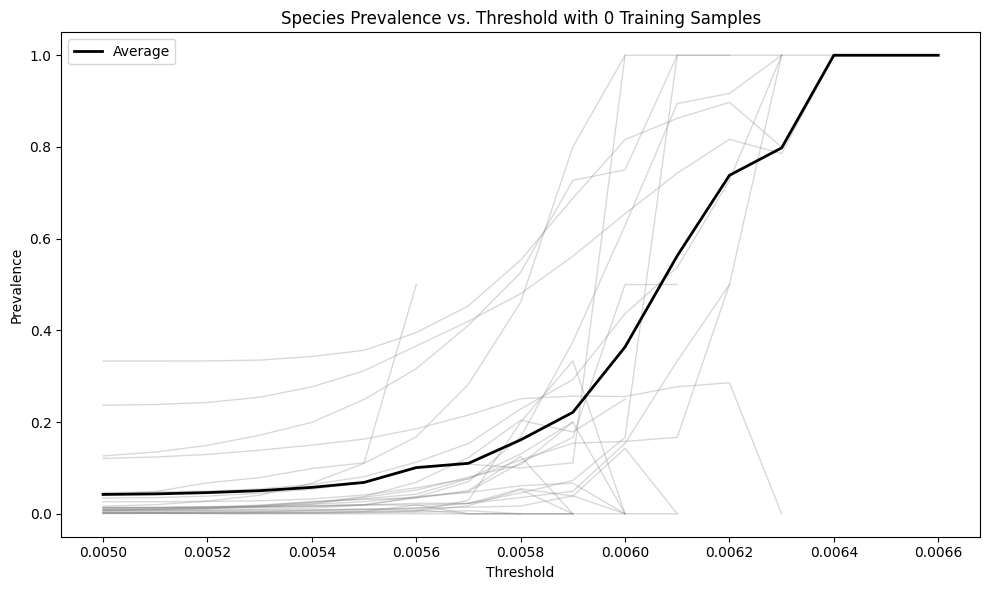

In [217]:

# Build threshold grid
all_thresholds = sorted(set(t for vals in filtered.values() for t, _, _ in vals))

# Interpolate prevalence values onto common grid
species_curves = []
for s, vals in filtered.items():
    tvals, pvals = zip(*[(t, p) for t, p, _ in vals])
    tvals = np.array(tvals)
    pvals = np.array(pvals)
    # Interpolation
    interp = np.interp(all_thresholds, tvals, pvals, left=np.nan, right=np.nan)
    species_curves.append(interp)

species_curves = np.array(species_curves)
avg_curve = np.nanmean(species_curves, axis=0)

# Plot
plt.figure(figsize=(10, 6))

# Faint lines for each species
for curve in species_curves:
    plt.plot(all_thresholds, curve, color="gray", alpha=0.3, linewidth=1)

# Dark average line
plt.plot(all_thresholds, avg_curve, color="black", linewidth=2, label="Average")

plt.xlabel("Threshold")
plt.ylabel("Prevalence")
plt.title("Species Prevalence vs. Threshold with 0 Training Samples")
plt.legend()
plt.tight_layout()
plt.show()

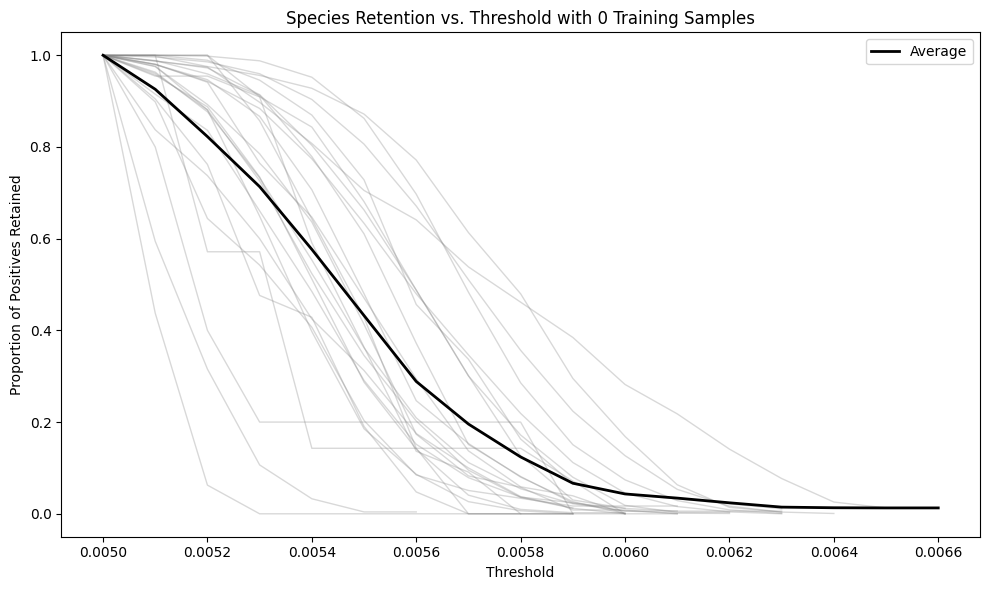

In [218]:

# Interpolate retention
species_curves = []
for s, vals in filtered.items():
    tvals, _, nvals = zip(*vals)
    tvals = np.array(tvals)
    nvals = np.array(nvals, dtype=float)
    n0 = nvals[0]  # initial positives
    retention = nvals / n0

    # interpolate to common grid
    interp = np.interp(all_thresholds, tvals, retention, left=np.nan, right=np.nan)
    species_curves.append(interp)

species_curves = np.array(species_curves)
avg_curve = np.nanmean(species_curves, axis=0)

# Plot
plt.figure(figsize=(10, 6))
for curve in species_curves:
    plt.plot(all_thresholds, curve, color="gray", alpha=0.3, linewidth=1)

plt.plot(all_thresholds, avg_curve, color="black", linewidth=2, label="Average")

plt.xlabel("Threshold")
plt.ylabel("Proportion of Positives Retained")
plt.title("Species Retention vs. Threshold with 0 Training Samples")
plt.legend()
plt.tight_layout()
plt.show()